## VLM Pilot Study

This code is our first implementation extension on the paper by Burns et al [2022] and goes through us analyzing and understanding the logit values and how they are interacting with n=3000 samples extracted from the POPE Dataset and how similarity scores can be compared for a contrastive pair of questions

For each Dataset point in Pope, We convert it into a contrastive pair of questions such as:

Original Question : Is there a cat in the image?


Positive Contrastive Pair ($x^+$) : The Image Contains a Cat (True Statement)

Negative Contrastive Pair ($x^-$) : The Image Contains a Cat (False Statement)

Once we find this out we do a similarity score test on both the questions and the image embeddings to see if the model is able to identify the correct pair from the incorrect pair

The code also runs some ad hoc statistics to see how the model performs and which parts of the dataset the model hallucinates on which gives us a brief idea into the inspiration for our approach

> Note: This was just a study code to see if we are able to Use the concept of Similarity to extract hidden meaning behind the questions and once we were confident that is when we moved on to the extension of CCS onto Vision Languate models 

Loading CLIP model...
Using device: cuda
Loading POPE dataset...
Dataset size: 9000

Analyzing 5000 samples...


100%|██████████| 5000/5000 [04:09<00:00, 20.07it/s]



Results saved to pope_analysis_results.csv


<ipython-input-21-fb1f08ae9ac9>:196: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_confidence = results_df.groupby('confidence_bin')['correct'].mean()



Plots saved to pope_analysis_plots.png


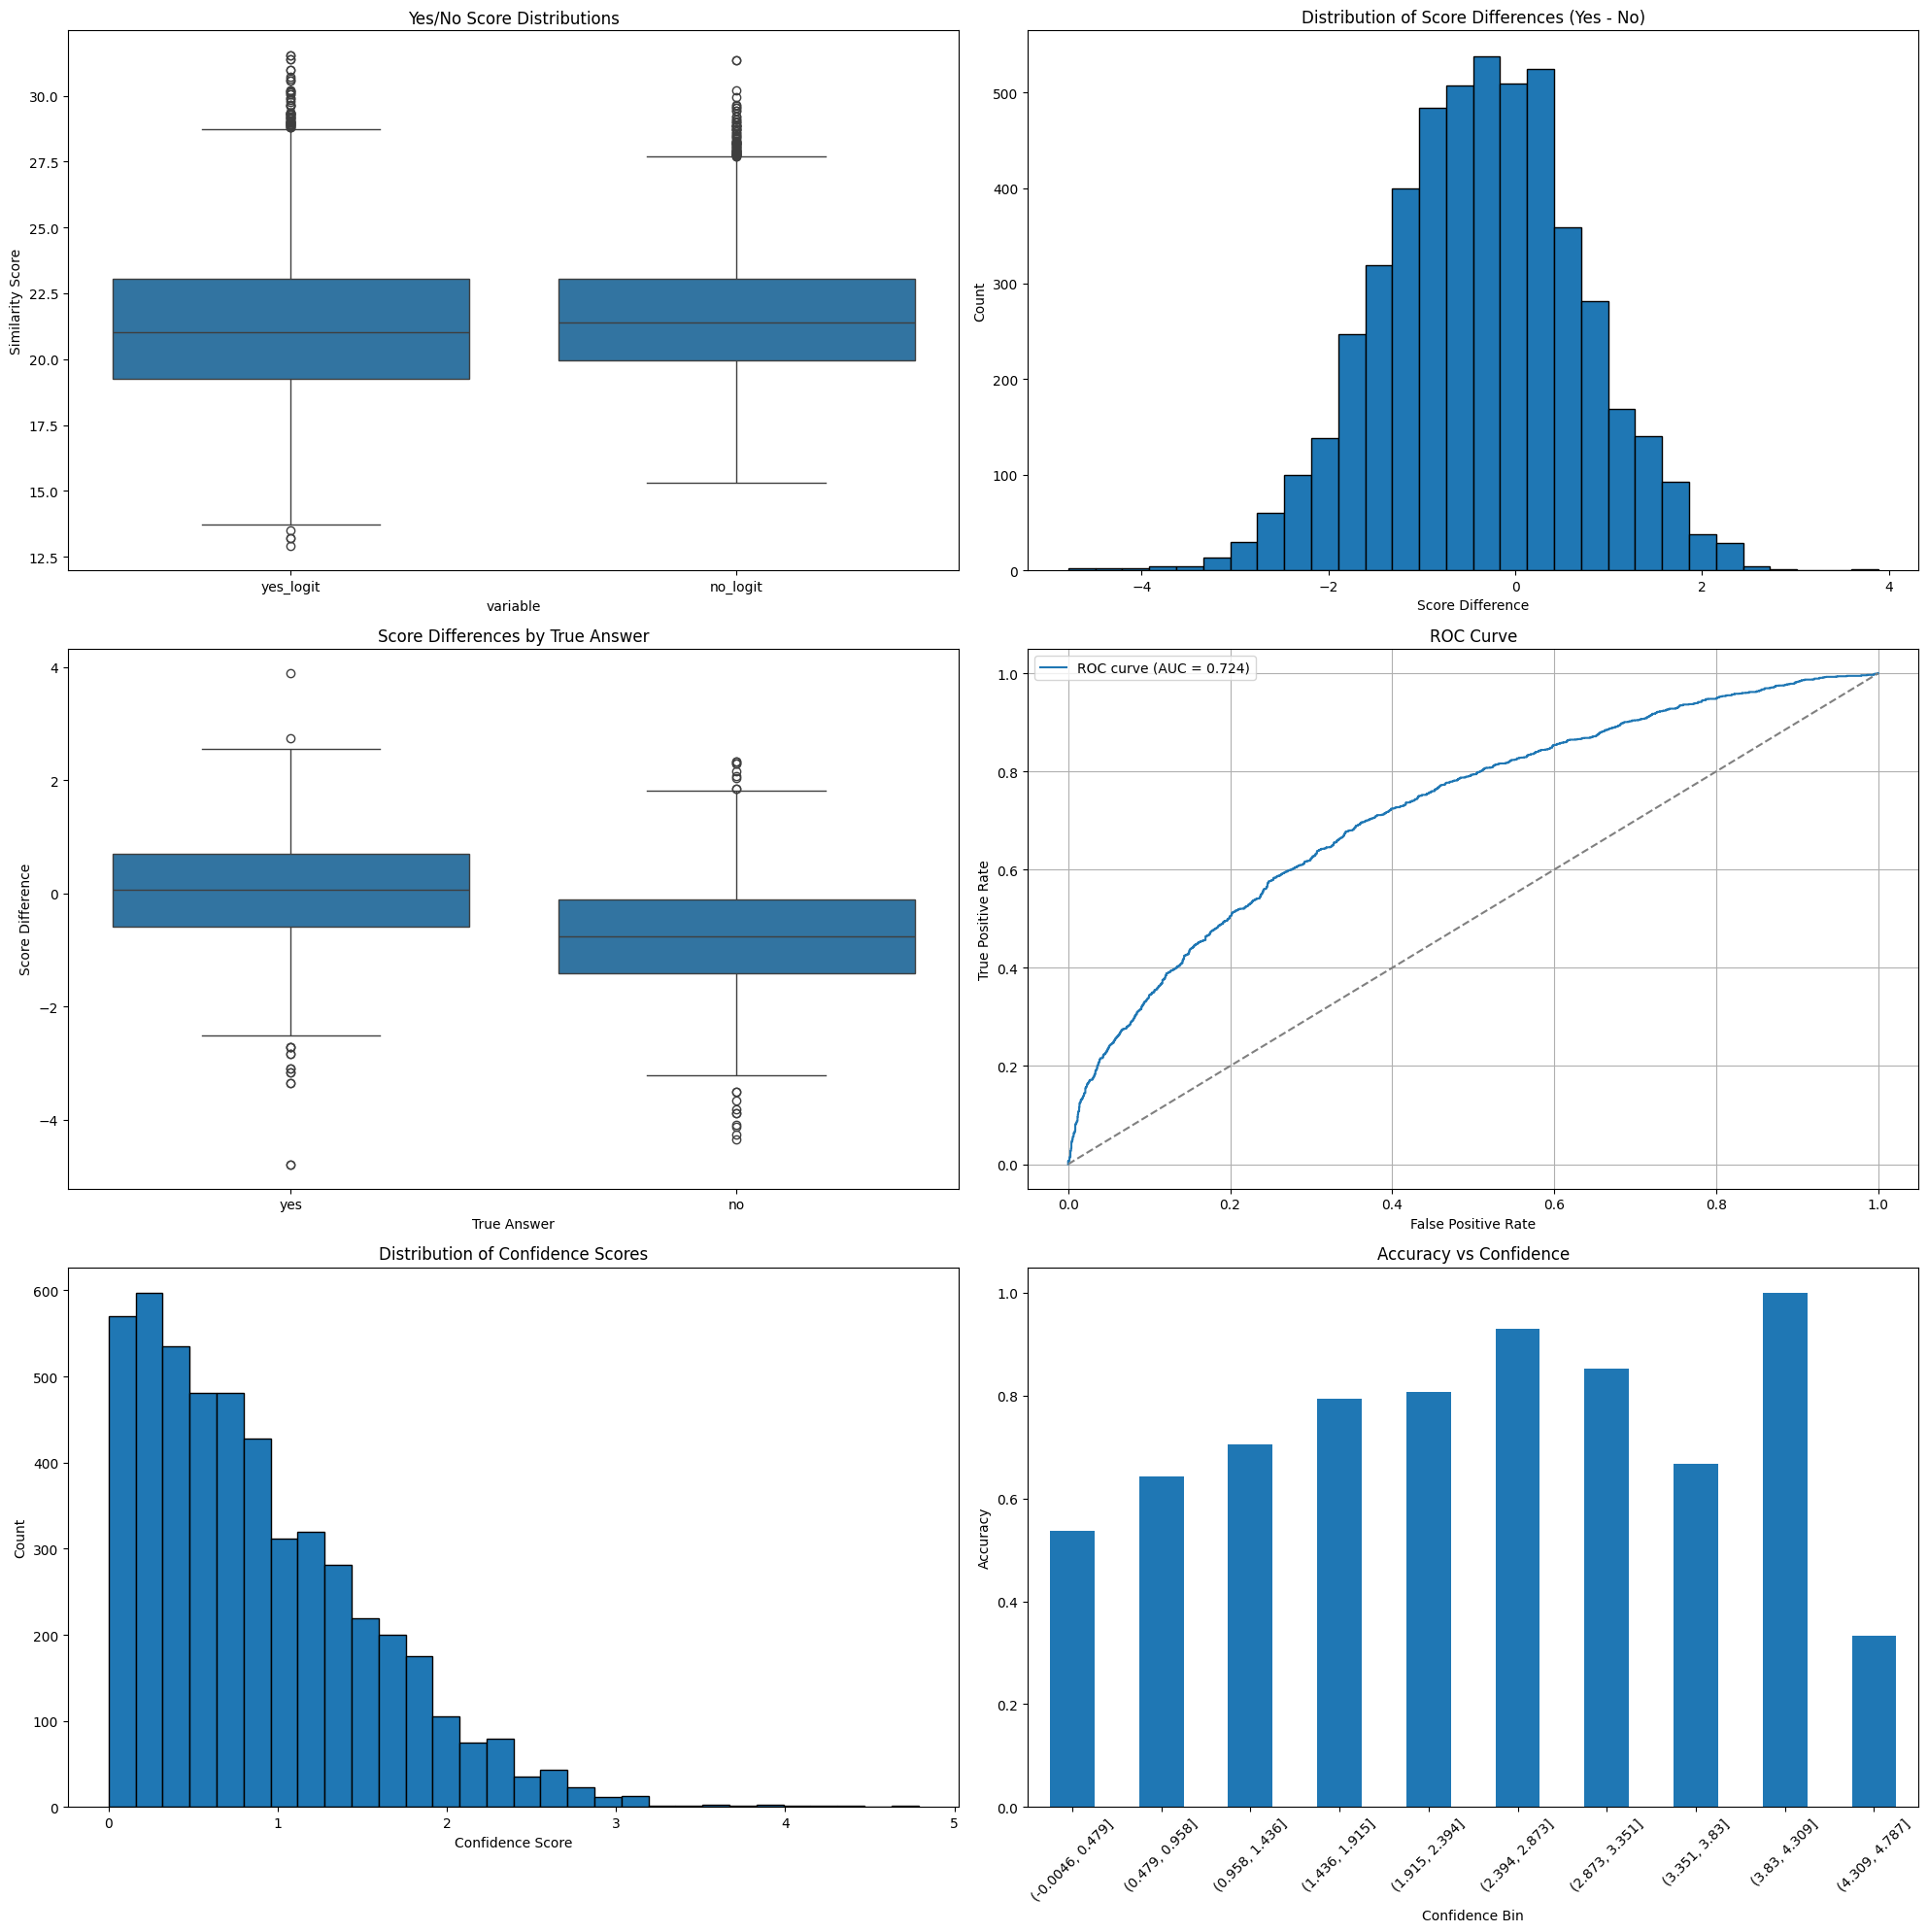


Summary Statistics:
         yes_logit     no_logit   logit_diff   confidence
count  5000.000000  5000.000000  5000.000000  5000.000000
mean     21.331671    21.697537    -0.365866     0.884086
std       2.916744     2.403772     1.050228     0.674611
min      12.911430    15.299303    -4.787470     0.000189
25%      19.243812    19.934572    -1.074343     0.341249
50%      21.036591    21.403690    -0.343679     0.748831
75%      23.057373    23.040192     0.336920     1.296708
max      31.548859    31.366009     3.885670     4.787470

Overall Model Accuracy: 65.24%

Accuracy by Category:
adversarial: 64.57%
popular: 66.25%

High Confidence Accuracy (confidence > 0.8): 74.85%

Example Predictions:

Question: Is there a motorcycle in the image?
Category: popular
Yes score: 27.372
No score: 25.975
Score diff: 1.397
Confidence: 1.397
True answer: yes
Predicted: yes
Top zero-shot label: car (score: 21.386)

Question: Is there a cup in the image?
Category: popular
Yes score: 22.220
No sco

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np

def analyze_pope_logits(num_samples=5000, save_results=True, confidence_threshold=0.5):
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Load CLIP
    print("Loading CLIP model...")
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    model = model.to(device)
    model.eval()

    # Load POPE dataset
    print("Loading POPE dataset...")
    dataset = load_dataset("lmms-lab/POPE", split='test')
    print(f"Dataset size: {len(dataset)}")

    # Store results
    results = []

    print(f"\nAnalyzing {num_samples} samples...")
    for idx in tqdm(range(num_samples)):
        sample = dataset[idx]

        try:
            # Reformulate questions as statements
            question = sample['question']
            yes_text = reformulate_question(question, "yes")
            no_text = reformulate_question(question, "no")

            # Process inputs
            inputs = processor(
                images=[sample['image']],
                text=[yes_text, no_text],
                return_tensors="pt",
                padding=True
            )

            # Move to device
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Get features
            with torch.no_grad():
                # Get image and text features
                image_features = model.get_image_features(inputs['pixel_values'])
                text_features = model.get_text_features(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask']
                )

                # Normalize features
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)

                # Compute similarity scores
                similarity = 100 * image_features @ text_features.T

                yes_score = similarity[0, 0].item()
                no_score = similarity[0, 1].item()

            # Perform zero-shot classification
            zero_shot_labels = ["dog", "cat", "car", "person", "tree", "building"]
            zero_shot_scores = zero_shot_classification(model, processor, sample['image'], zero_shot_labels, device)

            results.append({
                'question': question,
                'yes_logit': yes_score,
                'no_logit': no_score,
                'logit_diff': yes_score - no_score,
                'true_answer': sample['answer'],
                'category': sample['category'],
                'confidence': abs(yes_score - no_score),
                'zero_shot_top_label': zero_shot_labels[np.argmax(zero_shot_scores)],
                'zero_shot_top_score': np.max(zero_shot_scores)
            })

        except Exception as e:
            print(f"Error processing sample {idx}: {str(e)}")
            continue

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Save results if requested
    if save_results:
        results_df.to_csv('pope_analysis_results.csv', index=False)
        print("\nResults saved to pope_analysis_results.csv")

    # Create visualizations
    create_visualizations(results_df)

    # Calculate and print statistics
    print_statistics(results_df, confidence_threshold)

    # Perform error analysis
    error_analysis(results_df)

    return results_df

def reformulate_question(question, answer):
    # Remove "Is there" or "Are there" from the beginning of the question
    statement = question.replace("Is there ", "").replace("Are there ", "")

    # Remove question mark
    statement = statement.rstrip("?")

    # Add appropriate prefix based on the answer
    if answer == "yes":
        return f"This image contains {statement}"
    else:
        return f"This image does not contain {statement}"

def zero_shot_classification(model, processor, image, labels, device):
    inputs = processor(
        images=[image],
        text=[f"a photo of a {label}" for label in labels],
        return_tensors="pt",
        padding=True
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        image_features = model.get_image_features(inputs['pixel_values'])
        text_features = model.get_text_features(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask']
        )

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        similarity = 100 * image_features @ text_features.T

    return similarity[0].cpu().numpy()

def create_visualizations(results_df):
    fig = plt.figure(figsize=(20, 20))

    # Plot 1: Logit distributions
    plt.subplot(3, 2, 1)
    data_melted = pd.melt(results_df, value_vars=['yes_logit', 'no_logit'])
    sns.boxplot(x='variable', y='value', data=data_melted)
    plt.title('Yes/No Score Distributions', fontsize=12)
    plt.ylabel('Similarity Score')

    # Plot 2: Score differences histogram
    plt.subplot(3, 2, 2)
    plt.hist(results_df['logit_diff'], bins=30, edgecolor='black')
    plt.title('Distribution of Score Differences (Yes - No)', fontsize=12)
    plt.xlabel('Score Difference')
    plt.ylabel('Count')

    # Plot 3: Score differences by true answer
    plt.subplot(3, 2, 3)
    sns.boxplot(x='true_answer', y='logit_diff', data=results_df)
    plt.title('Score Differences by True Answer', fontsize=12)
    plt.xlabel('True Answer')
    plt.ylabel('Score Difference')

    # Plot 4: ROC curve
    plt.subplot(3, 2, 4)
    fpr, tpr, _ = roc_curve((results_df['true_answer'] == 'yes').astype(int), results_df['logit_diff'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title('ROC Curve', fontsize=12)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)

    # Plot 5: Confidence distribution
    plt.subplot(3, 2, 5)
    plt.hist(results_df['confidence'], bins=30, edgecolor='black')
    plt.title('Distribution of Confidence Scores', fontsize=12)
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')

    # Plot 6: Accuracy vs Confidence
    plt.subplot(3, 2, 6)
    results_df['correct'] = ((results_df['logit_diff'] > 0) & (results_df['true_answer'] == 'yes')) | \
                            ((results_df['logit_diff'] <= 0) & (results_df['true_answer'] == 'no'))
    results_df['confidence_bin'] = pd.cut(results_df['confidence'], bins=10)
    accuracy_by_confidence = results_df.groupby('confidence_bin')['correct'].mean()
    accuracy_by_confidence.plot(kind='bar')
    plt.title('Accuracy vs Confidence', fontsize=12)
    plt.xlabel('Confidence Bin')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('pope_analysis_plots.png', dpi=300, bbox_inches='tight')
    print("\nPlots saved to pope_analysis_plots.png")
    plt.show()

def print_statistics(results_df, confidence_threshold):
    print("\nSummary Statistics:")
    print(results_df[['yes_logit', 'no_logit', 'logit_diff', 'confidence']].describe())

    # Calculate accuracy
    accuracy = calculate_accuracy(results_df)
    print(f"\nOverall Model Accuracy: {accuracy:.2%}")

    # Calculate accuracy by category
    print("\nAccuracy by Category:")
    for category in results_df['category'].unique():
        cat_mask = results_df['category'] == category
        cat_accuracy = calculate_accuracy(results_df[cat_mask])
        print(f"{category}: {cat_accuracy:.2%}")

    # High confidence accuracy
    high_conf_mask = results_df['confidence'] > confidence_threshold
    high_conf_accuracy = calculate_accuracy(results_df[high_conf_mask])
    print(f"\nHigh Confidence Accuracy (confidence > {confidence_threshold}): {high_conf_accuracy:.2%}")

    # Print example predictions
    print("\nExample Predictions:")
    for _, row in results_df.sample(5).iterrows():
        print(f"\nQuestion: {row['question']}")
        print(f"Category: {row['category']}")
        print(f"Yes score: {row['yes_logit']:.3f}")
        print(f"No score: {row['no_logit']:.3f}")
        print(f"Score diff: {row['logit_diff']:.3f}")
        print(f"Confidence: {row['confidence']:.3f}")
        print(f"True answer: {row['true_answer']}")
        print(f"Predicted: {'yes' if row['logit_diff'] > 0 else 'no'}")
        print(f"Top zero-shot label: {row['zero_shot_top_label']} (score: {row['zero_shot_top_score']:.3f})")

def calculate_accuracy(df):
    return (((df['logit_diff'] > 0) & (df['true_answer'] == 'yes')) |
            ((df['logit_diff'] <= 0) & (df['true_answer'] == 'no'))).mean()

def error_analysis(results_df):
    print("\nError Analysis:")

    # Confusion Matrix
    y_true = (results_df['true_answer'] == 'yes').astype(int)
    y_pred = (results_df['logit_diff'] > 0).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    print("\nConfusion Matrix:")
    print(cm)

    # Error rate by category
    print("\nError rate by category:")
    for category in results_df['category'].unique():
        cat_mask = results_df['category'] == category
        cat_error_rate = 1 - calculate_accuracy(results_df[cat_mask])
        print(f"{category}: {cat_error_rate:.2%}")

    # Analyze misclassifications
    misclassified = results_df[((results_df['logit_diff'] > 0) & (results_df['true_answer'] == 'no')) |
                               ((results_df['logit_diff'] <= 0) & (results_df['true_answer'] == 'yes'))]

    print("\nTop misclassified categories:")
    print(misclassified['category'].value_counts().head())

    print("\nSample of misclassified instances:")
    for _, row in misclassified.sample(min(5, len(misclassified))).iterrows():
        print(f"\nQuestion: {row['question']}")
        print(f"Category: {row['category']}")
        print(f"True answer: {row['true_answer']}")
        print(f"Predicted: {'yes' if row['logit_diff'] > 0 else 'no'}")
        print(f"Confidence: {row['confidence']:.3f}")
        print(f"Top zero-shot label: {row['zero_shot_top_label']} (score: {row['zero_shot_top_score']:.3f})")

def main():
    try:
        results = analyze_pope_logits(num_samples=5000, confidence_threshold=0.8)
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Loading CLIP model...
Using device: cuda
Loading POPE dataset...
Dataset size: 9000

Analyzing 5000 samples...


100%|██████████| 5000/5000 [04:22<00:00, 19.06it/s]



Results saved to pope_analysis_results.csv


<ipython-input-4-c92bb8419cd9>:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_confidence = results_df.groupby('confidence_bin')['correct'].mean()



Plots saved to pope_analysis_plots.png


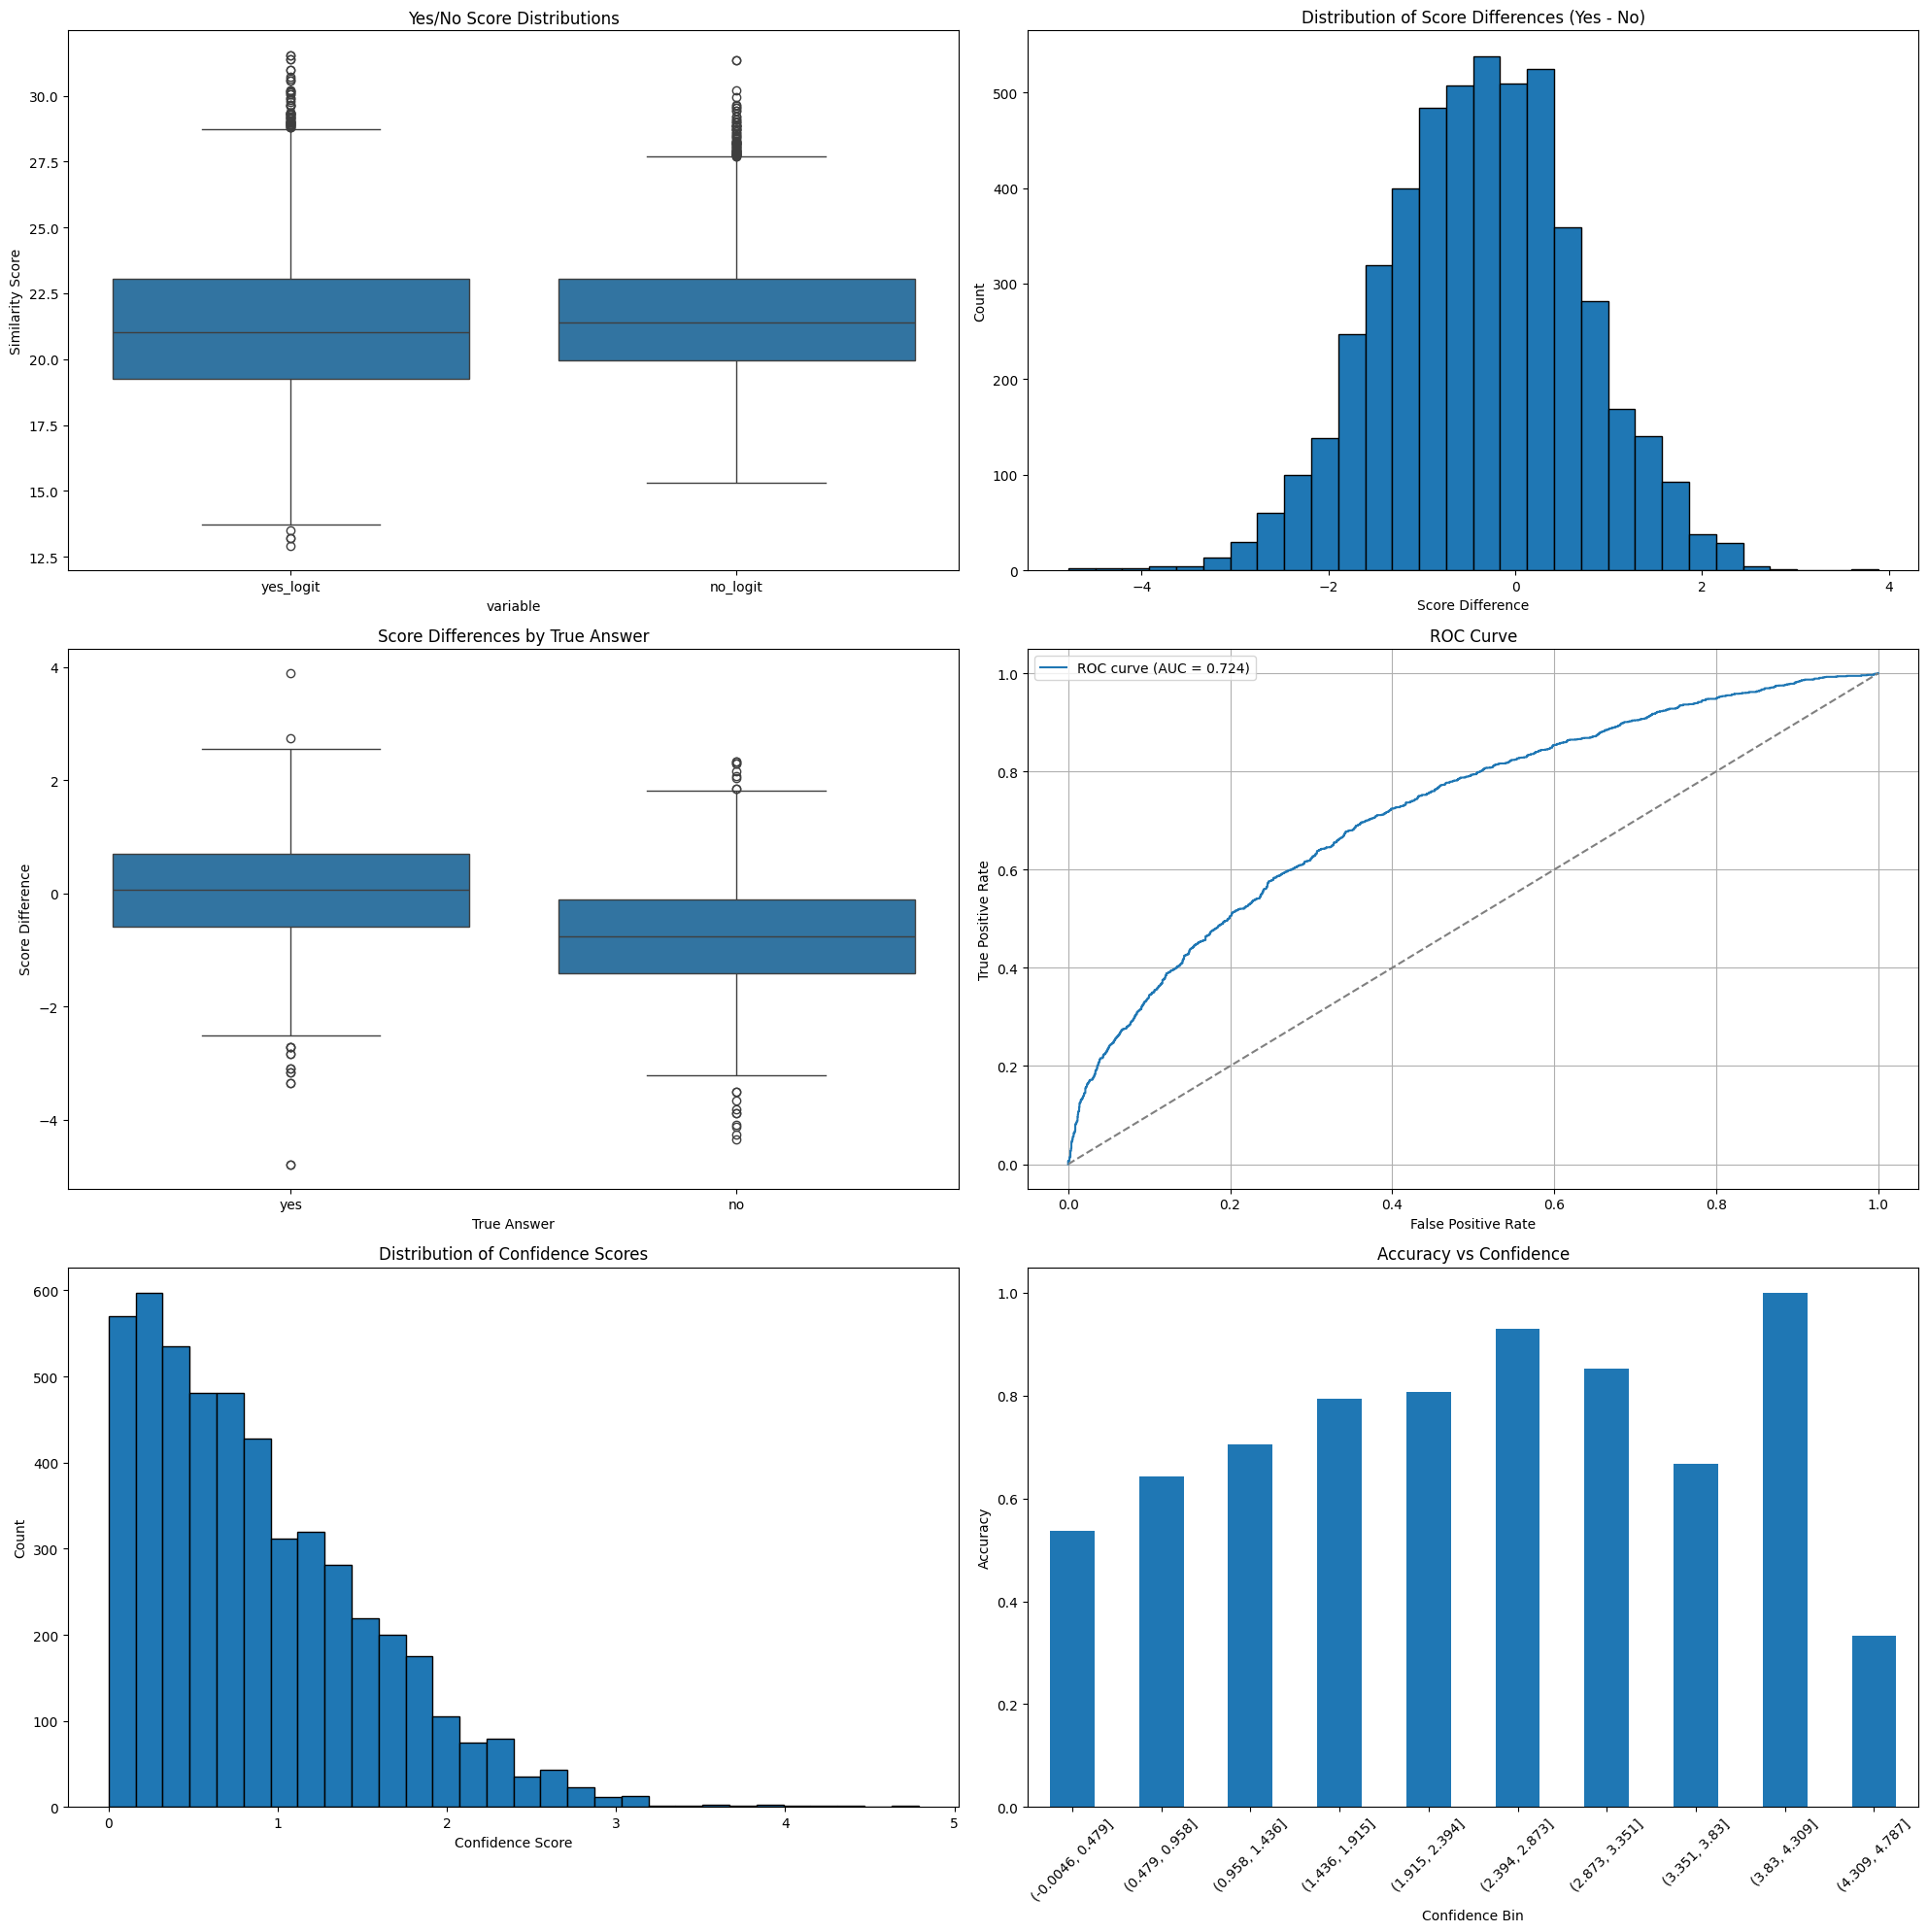


Summary Statistics:
         yes_logit     no_logit   logit_diff   confidence
count  5000.000000  5000.000000  5000.000000  5000.000000
mean     21.331671    21.697537    -0.365866     0.884086
std       2.916744     2.403772     1.050228     0.674611
min      12.911430    15.299303    -4.787470     0.000189
25%      19.243812    19.934572    -1.074343     0.341249
50%      21.036591    21.403690    -0.343679     0.748831
75%      23.057373    23.040192     0.336920     1.296708
max      31.548859    31.366009     3.885670     4.787470

Overall Model Accuracy: 65.24%

Accuracy by Category:
adversarial: 64.57%
popular: 66.25%

High Confidence Accuracy (confidence > 0.8): 74.85%

Example Predictions:

Question: Is there a knife in the image?
Category: adversarial
Yes score: 20.878
No score: 20.607
Score diff: 0.271
Confidence: 0.271
True answer: yes
Predicted: yes
Top zero-shot label: car (score: 20.852)

Question: Is there a truck in the image?
Category: adversarial
Yes score: 19.095
N

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np

def analyze_pope_logits(num_samples=5000, save_results=True, confidence_threshold=0.5):
    torch.manual_seed(42)

    print("Loading CLIP model...")
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    model = model.to(device)
    model.eval()

    print("Loading POPE dataset...")
    dataset = load_dataset("lmms-lab/POPE", split='test')
    print(f"Dataset size: {len(dataset)}")

    results = []
    print(f"\nAnalyzing {num_samples} samples...")
    for idx in tqdm(range(num_samples)):
        sample = dataset[idx]
        try:
            question = sample['question']
            yes_text = reformulate_question(question, "yes")
            no_text = reformulate_question(question, "no")

            inputs = processor(
                images=[sample['image']],
                text=[yes_text, no_text],
                return_tensors="pt",
                padding=True
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                image_features = model.get_image_features(inputs['pixel_values'])
                text_features = model.get_text_features(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask']
                )

                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)

                similarity = 100 * image_features @ text_features.T
                yes_score = similarity[0, 0].item()
                no_score = similarity[0, 1].item()

            zero_shot_labels = ["dog", "cat", "car", "person", "tree", "building"]
            zero_shot_scores = zero_shot_classification(model, processor, sample['image'], zero_shot_labels, device)

            results.append({
                'question': question,
                'yes_logit': yes_score,
                'no_logit': no_score,
                'logit_diff': yes_score - no_score,
                'true_answer': sample['answer'],
                'category': sample['category'],
                'confidence': abs(yes_score - no_score),
                'zero_shot_top_label': zero_shot_labels[np.argmax(zero_shot_scores)],
                'zero_shot_top_score': np.max(zero_shot_scores)
            })
        except Exception as e:
            print(f"Error processing sample {idx}: {str(e)}")
            continue

    results_df = pd.DataFrame(results)

    if save_results:
        results_df.to_csv('pope_analysis_results.csv', index=False)
        print("\nResults saved to pope_analysis_results.csv")

    create_visualizations(results_df)
    print_statistics(results_df, confidence_threshold)
    error_analysis(results_df)

    return results_df

def reformulate_question(question, answer):
    statement = question.replace("Is there ", "").replace("Are there ", "")
    statement = statement.rstrip("?")
    if answer == "yes":
        return f"This image contains {statement}"
    else:
        return f"This image does not contain {statement}"

def zero_shot_classification(model, processor, image, labels, device):
    inputs = processor(
        images=[image],
        text=[f"a photo of a {label}" for label in labels],
        return_tensors="pt",
        padding=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        image_features = model.get_image_features(inputs['pixel_values'])
        text_features = model.get_text_features(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask']
        )

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        similarity = 100 * image_features @ text_features.T

    return similarity[0].cpu().numpy()

def create_visualizations(results_df):
    fig = plt.figure(figsize=(20, 20))

    plt.subplot(3, 2, 1)
    data_melted = pd.melt(results_df, value_vars=['yes_logit', 'no_logit'])
    sns.boxplot(x='variable', y='value', data=data_melted)
    plt.title('Yes/No Score Distributions', fontsize=12)
    plt.ylabel('Similarity Score')

    plt.subplot(3, 2, 2)
    plt.hist(results_df['logit_diff'], bins=30, edgecolor='black')
    plt.title('Distribution of Score Differences (Yes - No)', fontsize=12)
    plt.xlabel('Score Difference')
    plt.ylabel('Count')

    plt.subplot(3, 2, 3)
    sns.boxplot(x='true_answer', y='logit_diff', data=results_df)
    plt.title('Score Differences by True Answer', fontsize=12)
    plt.xlabel('True Answer')
    plt.ylabel('Score Difference')

    plt.subplot(3, 2, 4)
    fpr, tpr, _ = roc_curve((results_df['true_answer'] == 'yes').astype(int), results_df['logit_diff'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title('ROC Curve', fontsize=12)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 5)
    plt.hist(results_df['confidence'], bins=30, edgecolor='black')
    plt.title('Distribution of Confidence Scores', fontsize=12)
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')

    plt.subplot(3, 2, 6)
    results_df['correct'] = ((results_df['logit_diff'] > 0) & (results_df['true_answer'] == 'yes')) | \
                            ((results_df['logit_diff'] <= 0) & (results_df['true_answer'] == 'no'))
    results_df['confidence_bin'] = pd.cut(results_df['confidence'], bins=10)
    accuracy_by_confidence = results_df.groupby('confidence_bin')['correct'].mean()
    accuracy_by_confidence.plot(kind='bar')
    plt.title('Accuracy vs Confidence', fontsize=12)
    plt.xlabel('Confidence Bin')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('pope_analysis_plots.png', dpi=300, bbox_inches='tight')
    print("\nPlots saved to pope_analysis_plots.png")
    plt.show()

def print_statistics(results_df, confidence_threshold):
    print("\nSummary Statistics:")
    print(results_df[['yes_logit', 'no_logit', 'logit_diff', 'confidence']].describe())

    accuracy = calculate_accuracy(results_df)
    print(f"\nOverall Model Accuracy: {accuracy:.2%}")

    print("\nAccuracy by Category:")
    for category in results_df['category'].unique():
        cat_mask = results_df['category'] == category
        cat_accuracy = calculate_accuracy(results_df[cat_mask])
        print(f"{category}: {cat_accuracy:.2%}")

    high_conf_mask = results_df['confidence'] > confidence_threshold
    high_conf_accuracy = calculate_accuracy(results_df[high_conf_mask])
    print(f"\nHigh Confidence Accuracy (confidence > {confidence_threshold}): {high_conf_accuracy:.2%}")

    print("\nExample Predictions:")
    for _, row in results_df.sample(5).iterrows():
        print(f"\nQuestion: {row['question']}")
        print(f"Category: {row['category']}")
        print(f"Yes score: {row['yes_logit']:.3f}")
        print(f"No score: {row['no_logit']:.3f}")
        print(f"Score diff: {row['logit_diff']:.3f}")
        print(f"Confidence: {row['confidence']:.3f}")
        print(f"True answer: {row['true_answer']}")
        print(f"Predicted: {'yes' if row['logit_diff'] > 0 else 'no'}")
        print(f"Top zero-shot label: {row['zero_shot_top_label']} (score: {row['zero_shot_top_score']:.3f})")

def calculate_accuracy(df):
    return (((df['logit_diff'] > 0) & (df['true_answer'] == 'yes')) |
            ((df['logit_diff'] <= 0) & (df['true_answer'] == 'no'))).mean()

def error_analysis(results_df):
    print("\nError Analysis:")

    y_true = (results_df['true_answer'] == 'yes').astype(int)
    y_pred = (results_df['logit_diff'] > 0).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    print("\nError rate by category:")
    for category in results_df['category'].unique():
        cat_mask = results_df['category'] == category
        cat_error_rate = 1 - calculate_accuracy(results_df[cat_mask])
        print(f"{category}: {cat_error_rate:.2%}")

    misclassified = results_df[((results_df['logit_diff'] > 0) & (results_df['true_answer'] == 'no')) |
                               ((results_df['logit_diff'] <= 0) & (results_df['true_answer'] == 'yes'))]
    print("\nTop misclassified categories:")
    print(misclassified['category'].value_counts().head())

    print("\nSample of misclassified instances:")
    for _, row in misclassified.sample(min(5, len(misclassified))).iterrows():
        print(f"\nQuestion: {row['question']}")
        print(f"Category: {row['category']}")
        print(f"True answer: {row['true_answer']}")
        print(f"Predicted: {'yes' if row['logit_diff'] > 0 else 'no'}")
        print(f"Confidence: {row['confidence']:.3f}")
        print(f"Top zero-shot label: {row['zero_shot_top_label']} (score: {row['zero_shot_top_score']:.3f})")

def main():
    try:
        results = analyze_pope_logits(num_samples=5000, confidence_threshold=0.8)
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()